In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir('/content/drive/My Drive/COMS4705_NLP/hw3')

Mounted at /content/drive


In [1]:
from glob import glob
import os
os.getcwd()

'/Users/kaimihuang/Documents/Study/MA in Stat/COMSW4705 Natural Language Processing/Zhou Yu/HW3'

In [3]:
glob('./*')

['./snli_1.0_train.jsonl',
 './hidden_states_5.pkl',
 './hidden_states_10.pkl',
 './hidden_states_0.pkl',
 './Copy of hw3.ipynb',
 './hw3.ipynb',
 './final_tuples_1_0.pkl',
 './final_tuples_1_5.pkl',
 './final_tuples_1_10.pkl',
 './hw3-3.ipynb']

# Preparation

In [2]:
import json
json_file = 'snli_1.0_train.jsonl'
snli_train_datalist = []

#read the corpus and create a list of the dictionaries in the corpus
with open(json_file, 'r') as f:
  for line in f:
    snli_train_data = json.loads(line)
    snli_train_datalist.append(snli_train_data)

In [3]:
#remove samples whose gold labels are '-'
snli_train_datalist = [d for d in snli_train_datalist if d['gold_label'] != '-']

#sanity check
for dic in snli_train_datalist:
  if dic['gold_label'] == '-':
    print(dic)

In [4]:
#sample 500 samples from the corpus

#generate 500 random numbers between 0 and len(corpus)
import random
start = 0
end = len(snli_train_datalist)
sample_size = 500
random_sample = random.sample(range(start, end), sample_size)

#get just the gold_label, sent1 & sent 2 from the samples
samples = []
for ind in random_sample:
  placeholder = {}
  sample = snli_train_datalist[ind]
  placeholder['gold_label'] = sample['gold_label']
  placeholder['sentence1'] = sample['sentence1']
  placeholder['sentence2'] = sample['sentence2']
  samples.append(placeholder)

In [5]:
!pip install transformers

In [6]:
import torch
from torch import nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel

/Users/kaimihuang/opt/anaconda3/envs/ML-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2 = gpt2#.to("cuda")

In [9]:
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
pip install git+https://github.com/davidbau/baukit

  Cloning https://github.com/davidbau/baukit to /private/var/folders/6t/qq3z1qdx60s0sj_h80x_2wz40000gn/T/pip-req-build-b0rgt1np
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /private/var/folders/6t/qq3z1qdx60s0sj_h80x_2wz40000gn/T/pip-req-build-b0rgt1np
  Resolved https://github.com/davidbau/baukit to commit 5e23007c02fd58f063200c5dc9033e90f092630d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [11]:
from baukit import TraceDict

# Obtain Internal States

In [21]:
#construct prompts so that each data item is a single string in the following format
#combined_sentences = “<sentence1> This has the same meaning as: <sentence2>”
string_1 = ' This has the same meaning as: '
train_tuples_1 = []
for sample in samples:
  sample['combined_sentences'] = sample['sentence1'] + string_1 + sample['sentence2']
  placeholder = (sample['gold_label'], sample['sentence1'], sample['sentence2'], sample['combined_sentences'])
  train_tuples_1.append(placeholder)

In [34]:
#construct prompts so that each data item is a single string in the following format
#combined_sentences = “<sentence1> In other words, <sentence2>”
string_2 = ' The previous sentence does not provide enough evidence for the following sentence: '
train_tuples_2 = []
for sample in samples:
  sample['combined_sentences'] = sample['sentence1'] + string_2 + sample['sentence2']
  placeholder = (sample['gold_label'], sample['sentence1'], sample['sentence2'], sample['combined_sentences'])
  train_tuples_2.append(placeholder)

In [35]:
train_tuples_1[4]

('neutral',
 'A man in a red windbreaker leaves his house with his keys.',
 'The man is dressed for a windy day as he starts his morning jog.',
 'A man in a red windbreaker leaves his house with his keys. This has the same meaning as: The man is dressed for a windy day as he starts his morning jog.')

In [38]:
train_tuples_2[2]

('contradiction',
 'A blue-colored racing sailboat sporting the number 5 and Oracle corporate logos is sailing just off a rocky beach with a grass-covered sloping hill.',
 'The boat is docked in the bay.',
 'A blue-colored racing sailboat sporting the number 5 and Oracle corporate logos is sailing just off a rocky beach with a grass-covered sloping hill. The previous sentence does not provide enough evidence for the following sentence: The boat is docked in the bay.')

In [39]:
#Here, you are essentially having GPT2 “force generate” the text you have in
#combined_sentences, and getting the state of h.0.mlp in GPT2 as it generates each token; 768
#is the size of each MLP hidden state for layer zero in GPT2.

final_tuples = {'h.0.mlp':[], 'h.5.mlp':[], 'h.10.mlp':[], 'h.5.attn':[]}
hidden_states = {'h.0.mlp':[], 'h.5.mlp':[], 'h.10.mlp':[], 'h.5.attn':[]}

def extract_gpt2_hiddenstates(train_tuples=list, string=str):
    for item in train_tuples:
      combined_sentence = item[3]
      sent1_string_combined = item[1]+string

      sent1_str_tokens = tokenizer(sent1_string_combined, return_tensors='pt')#.to('cuda')
      inputs = tokenizer(combined_sentence, return_tensors='pt')#.to('cuda')
      mlp_0 = 'transformer.h.0.mlp'
      mlp_5 = 'transformer.h.5.mlp'
      mlp_10 = 'transformer.h.10.mlp'


          #Feedforward Neural Network (MLP) is responsible for further processing the information obtained from the self-attention mechanism.
      with TraceDict(gpt2, [mlp_0, mlp_5, mlp_10]) as ret:
          outputs = gpt2(**inputs)
          # inputs['input_ids'].size() is equal to ret.output.size()[:2]
          representation_0 = ret[mlp_0].output[:, sent1_str_tokens['input_ids'].size(1):, :]
          representation_5 = ret[mlp_5].output[:, sent1_str_tokens['input_ids'].size(1):, :]
          representation_10 = ret[mlp_10].output[:, sent1_str_tokens['input_ids'].size(1):, :]

      placeholder = (item[0],item[1],item[2], representation_0)
      final_tuples['h.0.mlp'].append(placeholder)

      placeholder = (item[0],item[1],item[2], representation_5)
      final_tuples['h.5.mlp'].append(placeholder)

      placeholder = (item[0],item[1],item[2], representation_10)
      final_tuples['h.10.mlp'].append(placeholder)

    return final_tuples

In [24]:
final_tuples_1 = extract_gpt2_hiddenstates(train_tuples_1, string_1)

In [46]:
final_tuples_1['h.5.mlp'][0]

('entailment',
 'Two hockey players are in the middle of a match and the man on the left is in the process of swinging his stick in the attempt of scoring.',
 'The hockey players are on the ice.',
 tensor([[[-0.3284, -0.3321,  0.2330,  ..., -0.7282,  0.3825,  0.5585],
          [ 0.4682,  0.1122, -0.0860,  ...,  0.3103, -0.0702,  0.3913],
          [ 0.9083, -0.4163, -0.1160,  ...,  0.0410, -0.3844,  0.0466],
          ...,
          [-0.3357, -0.7542, -0.6466,  ..., -0.2125,  0.7336, -1.0835],
          [ 0.6373, -0.7826, -0.2791,  ..., -1.2324,  0.8112,  0.8434],
          [ 0.7750, -0.1853,  0.0018,  ..., -0.6680,  0.4146,  0.2322]]],
        grad_fn=<SliceBackward0>))

In [40]:
final_tuples_2 = extract_gpt2_hiddenstates(train_tuples_2, string_2)

In [168]:
final_tuples_2['h.10.mlp'][4]

('neutral',
 'A man in a red windbreaker leaves his house with his keys.',
 'The man is dressed for a windy day as he starts his morning jog.',
 tensor([[[ 0.6445,  0.2134,  0.1796,  ...,  0.7305,  0.5466, -0.3165],
          [-0.5741, -2.2217, -0.4678,  ...,  1.6060, -1.5445,  0.2189],
          [-0.5062, -4.9092, -2.9950,  ...,  2.6122,  1.5282, -3.3927],
          ...,
          [ 0.6544, -2.5665,  1.9229,  ..., -1.9091, -0.3361, -0.8697],
          [ 1.0788, -4.1890, -1.4352,  ...,  0.1250, -1.0971,  1.5846],
          [-1.7902,  0.5997, -0.3742,  ...,  1.9956,  0.9574, -0.0242]]],
        grad_fn=<SliceBackward0>))

In [26]:
import pickle
# Its important to use binary mode
dbfile_1_0 = open('final_tuples_1_0.pkl', 'ab')
# source, destination
pickle.dump(final_tuples_1['h.0.mlp'], dbfile_1_0, protocol=pickle.HIGHEST_PROTOCOL)
dbfile_1_0.close()

dbfile_1_5 = open('final_tuples_1_5.pkl', 'ab')
pickle.dump(final_tuples_1['h.5.mlp'], dbfile_1_5, protocol=pickle.HIGHEST_PROTOCOL)
dbfile_1_5.close()

dbfile_1_10 = open('final_tuples_1_10.pkl', 'ab')
pickle.dump(final_tuples_1['h.10.mlp'], dbfile_1_10, protocol=pickle.HIGHEST_PROTOCOL)
dbfile_1_10.close()

In [49]:
import pickle
dbfile_2_0 = open('final_tuples_2_0.pkl', 'ab')
pickle.dump(final_tuples_2['h.0.mlp'], dbfile_2_0, protocol=pickle.HIGHEST_PROTOCOL)
dbfile_2_0.close()

dbfile_2_5 = open('final_tuples_2_5.pkl', 'ab')
pickle.dump(final_tuples_2['h.5.mlp'], dbfile_2_5, protocol=pickle.HIGHEST_PROTOCOL)
dbfile_2_5.close()

dbfile_2_10 = open('final_tuples_2_10.pkl', 'ab')
pickle.dump(final_tuples_2['h.10.mlp'], dbfile_2_10, protocol=pickle.HIGHEST_PROTOCOL)
dbfile_2_10.close()

In [52]:
#open pickle files that contain the other two hidden state datasets

with open('final_tuples_1_0.pkl', 'rb') as handle:
    dataset_1_0 = pickle.load(handle)

with open('final_tuples_1_5.pkl', 'rb') as handle:
    dataset_1_5 = pickle.load(handle)

with open('final_tuples_1_10.pkl', 'rb') as handle:
    dataset_1_10 = pickle.load(handle)

In [53]:
with open('final_tuples_2_0.pkl', 'rb') as handle:
    dataset_2_0 = pickle.load(handle)

with open('final_tuples_2_5.pkl', 'rb') as handle:
    dataset_2_5 = pickle.load(handle)

with open('final_tuples_2_10.pkl', 'rb') as handle:
    dataset_2_10 = pickle.load(handle)

# Add padding

In [54]:
import torch.nn as nn
import torch.nn.functional as F

#create a class to handle padding

def add_padding(final_tuples=list):

    #add padding and create dataset(tensor of hidden_state, label)
    labels = {'contradiction':0, 'entailment':1, 'neutral':2}
    dataset = []

    #find the maximum number of second dimension among hidden states
    #add padding
    #so that all hidden states have the same size (1, max_dim, 768)
    second_dims = []
    for tup in final_tuples:
      tensor = tup[-1]
      dim = tensor.shape[1]
      second_dims.append(dim)
      max_dim = max(second_dims)

    for tup in final_tuples:
      tensor = tup[-1]
      original_dim = tensor.shape[1]
      num_of_pads = max_dim - original_dim
      #(left, right, top, bottom, front, back)
      padding = [0,0,0,num_of_pads,0,0]
      padded_tensor = F.pad(tensor, padding)

      label = tup[0]
      label_ind = labels[label]

      dataset.append((padded_tensor,label_ind))

    return max_dim, dataset

In [55]:
#add padding to all 3 datasets
max_dim_1_0, padded_dataset_1_0 = add_padding(dataset_1_0)
max_dim_1_5, padded_dataset_1_5 = add_padding(dataset_1_5)
max_dim_1_10, padded_dataset_1_10 = add_padding(dataset_1_10)

max_dim_1_0, max_dim_1_5, max_dim_1_10

(25, 25, 25)

In [56]:
#add padding to all 3 datasets
max_dim_2_0, padded_dataset_2_0 = add_padding(dataset_2_0)
max_dim_2_5, padded_dataset_2_5 = add_padding(dataset_2_5)
max_dim_2_10, padded_dataset_2_10 = add_padding(dataset_2_10)

max_dim_2_0, max_dim_2_5, max_dim_2_10

(25, 25, 25)

# Split dataset into train, val, & test

In [109]:
from torch.utils.data import DataLoader
#separate dataset into train, validation, and testing sets
def data_split(dataset=list):
    train_data = []
    val_data = []
    test_data = []

    train_split = 0.6
    val_split = 0.2
    test_split = 0.2

    train_ss = int(sample_size*train_split)
    val_ss = int(sample_size*val_split)

    random.shuffle(dataset)

    train_data = dataset[:train_ss]
    val_data = dataset[train_ss:train_ss+val_ss]
    test_data = dataset[train_ss+val_ss:]

    #minibatches
    train_dataloader = DataLoader(train_data, batch_size=50, shuffle=True, drop_last=False)
    val_dataloader = DataLoader(val_data, batch_size=50, shuffle=True, drop_last=False)
    test_dataloader = DataLoader(test_data, batch_size=50, shuffle=True, drop_last=False)

    return train_dataloader, val_dataloader, test_dataloader

In [110]:
#split all 3 datasets into train, val, and test sets
train_dataloader_1_0, val_dataloader_1_0, test_dataloader_1_0 = data_split(padded_dataset_1_0)
train_dataloader_1_5, val_dataloader_1_5, test_dataloader_1_5 = data_split(padded_dataset_1_5)
train_dataloader_1_10, val_dataloader_1_10, test_dataloader_1_10 = data_split(padded_dataset_1_10)

for x_batch, y_batch in train_dataloader_1_0:
  print(x_batch.size(), y_batch.size())

torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])


In [111]:
for x_batch, y_batch in val_dataloader_1_0:
  print(x_batch.size(), y_batch.size())

torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])


In [112]:
for x_batch, y_batch in test_dataloader_1_0:
  print(x_batch.size(), y_batch.size())

torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])


In [113]:
#split all 3 datasets into train, val, and test sets
train_dataloader_2_0, val_dataloader_2_0, test_dataloader_2_0 = data_split(padded_dataset_2_0)
train_dataloader_2_5, val_dataloader_2_5, test_dataloader_2_5 = data_split(padded_dataset_2_5)
train_dataloader_2_10, val_dataloader_2_10, test_dataloader_2_10 = data_split(padded_dataset_2_10)

In [114]:
for x_batch, y_batch in train_dataloader_2_0:
  print(x_batch.size(), y_batch.size())

torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])
torch.Size([50, 1, 25, 768]) torch.Size([50])


# Train a Classifier

In [ ]:
# from torchsummary import summary

# #model_1: [max_dim,768] -> pool to max_dim,1 -> flatten -> 3 logits
# class Net_1(nn.Module):
#   def __init__(self, max_dim):
#     super().__init__()
#     self.max_dim = max_dim
#     self.pool = nn.MaxPool2d(kernel_size=(1,768))
#     self.fc1 = nn.Linear(self.max_dim, 9) #tried 128, 64, 32, 16 hidden units
#     self.fc2 = nn.Linear(9, 3)


#   def forward(self, x):
#     x = F.relu(self.pool(x))
#     x = torch.flatten(x, start_dim = 1) # flatten all dimensions except batch
#     x = F.relu(self.fc1(x))
#     x = self.fc2(x)
#     return x

# model_1 = Net_1(max_dim=max_dim_1_10).cuda()
# summary(model_1, input_size=(max_dim_1_10, 768))

In [138]:
#from torchsummary import summary

#model_1: [max_dim,768] -> pool to 1,768 -> flatten -> 3 logits
class Net_1(nn.Module):
  def __init__(self, max_dim):
    super().__init__()
    self.max_dim = max_dim
    self.pool = nn.MaxPool2d(kernel_size=(self.max_dim,1))
    self.fc1 = nn.Linear(768, 128) #tried 128, 64, 32, 16 hidden units
    #self.dropout = nn.Dropout(p=dropout_prob)
    self.fc2 = nn.Linear(128, 3)

  def forward(self, x):
    x = F.relu(self.pool(x))
    x = torch.flatten(x, start_dim = 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    #x = self.dropout(x)
    x = self.fc2(x)
    return x

# model_1 = Net_1(max_dim=max_dim_0).cuda()
# summary(model_1, input_size=(max_dim_0, 768))

In [ ]:
#model_2: [max_dim,768] -> pool to 2,768 -> flatten -> 3 logits
class Net_2(nn.Module):
  def __init__(self, max_dim):
    super().__init__()
    self.max_dim = max_dim
    self.window = int(self.max_dim/2)
    self.pool = nn.MaxPool2d(kernel_size=(self.window,1))
    self.fc1 = nn.Linear(768*2, 128)
    #self.dropout = nn.Dropout(p=dropout_prob)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    x = F.relu(self.pool(x))
    x = torch.flatten(x, start_dim = 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    #x = self.dropout(x)
    x = self.fc3(x)
    return x

# model_2 = Net_2(max_dim=max_dim_0).cuda()
# summary(model_2, input_size=(max_dim_0, 768))

In [ ]:
#model_3: [max_dim,768] -> pool to 2,768 -> flatten -> 3 logits
#tries dropout

class Net_3(nn.Module):
  def __init__(self, max_dim, dropout_prob):
    super().__init__()
    self.max_dim = max_dim
    self.window = int(self.max_dim/2)
    self.dropout_prob = dropout_prob
    self.pool = nn.MaxPool2d(kernel_size=(self.window,1))
    self.fc1 = nn.Linear(768*2, 128)
    self.dropout = nn.Dropout(p=self.dropout_prob)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    x = F.relu(self.pool(x))
    x = torch.flatten(x, start_dim = 1) # flatten all dimensions except batch
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# model_3 = Net_3(max_dim=max_dim_5, dropout_prob = 0.5).cuda()
# summary(model_3, input_size=(max_dim_5, 768))

In [ ]:
#model_4 simple fully connected: [max_dim,768] -> -> flatten -> 3 logits
#dropout

class Net_4(nn.Module):
  def __init__(self, max_dim, dropout_prob):
    super().__init__()
    self.max_dim = max_dim
    self.dropout_prob = dropout_prob
    self.dropout = nn.Dropout(p=self.dropout_prob)
    self.fc1 = nn.Linear(768*max_dim, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    x = torch.flatten(x, start_dim = 1) # flatten all dimensions except batch
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# model_4 = Net_4(max_dim=max_dim_0, dropout_prob=0.5).cuda()
# summary(model_4, input_size=(max_dim_0, 768))

In [ ]:
#model_5 simple fully connected: [max_dim,768] -> -> flatten -> 3 logits
#no dropout

class Net_5(nn.Module):
  def __init__(self, max_dim):
    super().__init__()
    self.max_dim = max_dim
    self.fc1 = nn.Linear(768*max_dim, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    x = torch.flatten(x, start_dim = 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# model_5 = Net_5(max_dim=max_dim_0).cuda()
# summary(model_5, input_size=(max_dim_0, 768))

In [64]:
def train_many_epochs(train_dataloader, val_dataloader, model, loss_function, optimizer, epochs):
    train_loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
      #print(f'Epoch {i + 1}')
      #for each mini batch, train using the optimzer
      model.train()
      epoch_train_loss = 0.0
      for x_batch, y_batch in train_dataloader:
          x = x_batch#.cuda()
          y = y_batch#.cuda()

          # Clear the gradients
          optimizer.zero_grad()

          # Forward
          # The forward method defines the forward pass of the network, which specifies how input data is processed through the layers to produce an output.
          logits = model(x)

          # Compute the batch loss, add L2 regularization
          loss = loss_fn(logits, y) + lambda_reg * sum(torch.sum(param**2) for param in model.parameters())

          # Backward/Calculate the gradients
          loss.backward()#retain_graph=True

          # Optimize/Update the parameteres
          optimizer.step()

          epoch_train_loss += loss.item()

      avg_train_loss = epoch_train_loss/len(train_dataloader)
      train_loss_list.append(avg_train_loss)

      model.eval()
      epoch_val_loss = 0.0
      with torch.no_grad():
        for xval_batch, yval_batch in val_dataloader:
          x_val = xval_batch#.cuda()
          y_val = yval_batch#.cuda()
          predicts = model(x_val)
          val_ce_loss = loss_fn(predicts, y_val)
          epoch_val_loss += val_ce_loss.item()

      avg_val_loss = epoch_val_loss/len(val_dataloader)
      val_loss_list.append(avg_val_loss)

    return (train_loss_list, val_loss_list)

In [65]:
# #evaluate
def evaluate(test_dataloader, model):
    with torch.no_grad():
      accuracy = 0.0
      for x_batch, y_batch in test_dataloader:
          x = x_batch#.cuda()
          y = y_batch#.cuda()
          outputs = model(x)
          predicts = outputs.argmax(dim=1)
          accuracy += (predicts == y).sum().item() #add .item() to return value instead of tensor
      accuracy /= len(test_dataloader.dataset)
      return accuracy

In [140]:
#loss/optimizer
from torch import optim
epoch_num = 40
lambda_reg = 0.09
learning_rate = 0.012495
#optimizer_Adam = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= lambda_reg)
#optimizer_SGD = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= lambda_reg)

In [67]:
import matplotlib.pyplot as plt
def plotting(epoch_num, train_loss_list, val_loss_list):
    epochs = range(1, epoch_num + 1)

    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

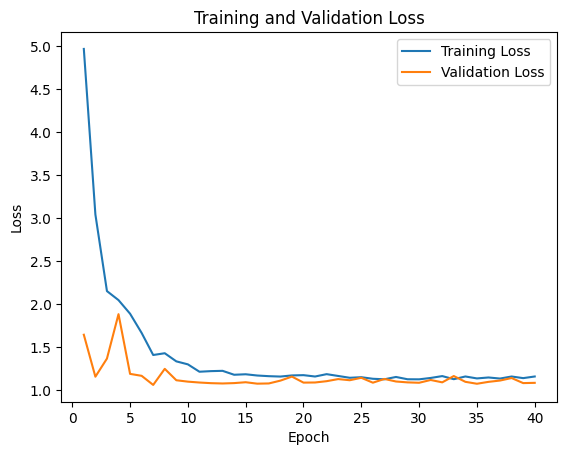


 Accuracy on test set is: 0.4


In [141]:
#'This has the same meaning as'
#0.mlp
model_1 = Net_1(max_dim=max_dim_1_0)#.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay= lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_1, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)
acc = evaluate(test_dataloader_1_0, model_1)
print(f'\n Accuracy on test set is: {acc}')

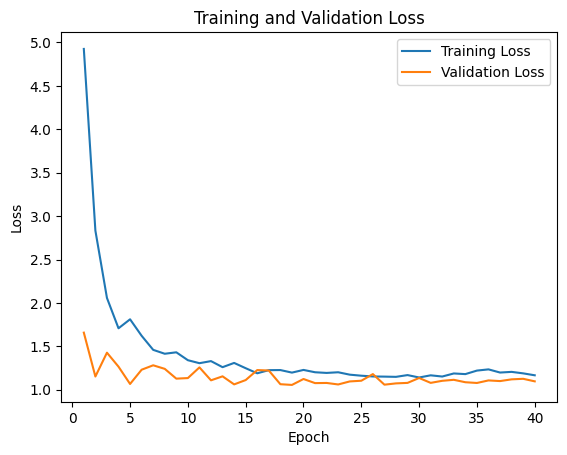


 Accuracy on test set is: 0.45


In [142]:
#Bonus Task 1 -
#0.mlp
model_1 = Net_1(max_dim=max_dim_2_0)#.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay= lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_2_0, val_dataloader_2_0, model_1, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)
acc = evaluate(test_dataloader_2_0, model_1)
print(f'\n Accuracy on test set is: {acc}')

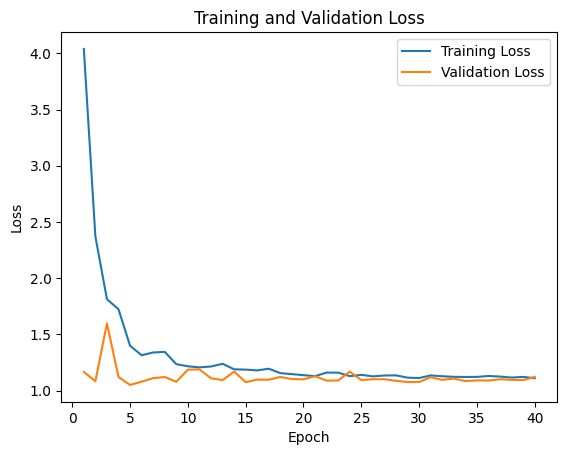


 Accuracy on test set is: 0.38


In [155]:
#'This has the same meaning as'
#mlp5 hidden states
model_1 = Net_1(max_dim=max_dim_1_0)#.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_1_5, val_dataloader_1_5, model_1, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)
acc = evaluate(test_dataloader_1_5, model_1)
print(f'\n Accuracy on test set is: {acc}')

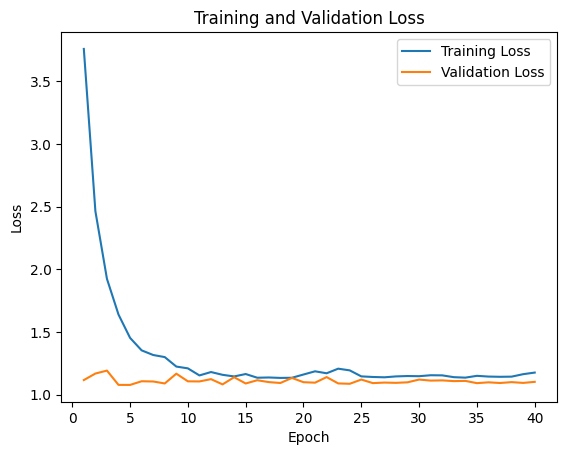


 Accuracy on test set is: 0.38


In [166]:
#Bonus Task 1 -
#mlp5 hidden states
model_1 = Net_1(max_dim=max_dim_2_0)#.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_2_5, val_dataloader_2_5, model_1, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)
acc = evaluate(test_dataloader_2_5, model_1)
print(f'\n Accuracy on test set is: {acc}')

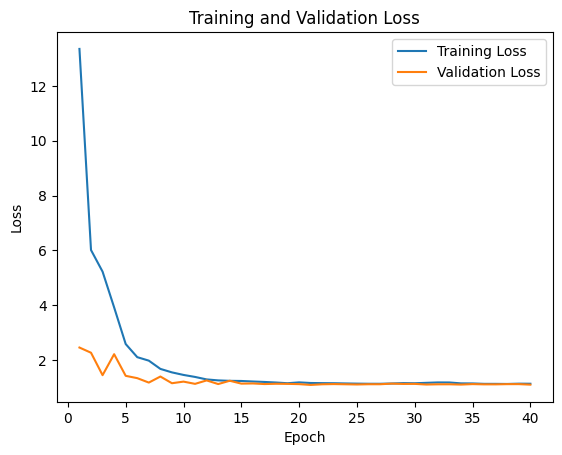


 Accuracy on test set is: 0.32


In [156]:
#'This has the same meaning as'
#mlp10 hidden states
model_1 = Net_1(max_dim=max_dim_1_0)#.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_1_10, val_dataloader_1_10, model_1, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)
acc = evaluate(test_dataloader_1_10, model_1)
print(f'\n Accuracy on test set is: {acc}')

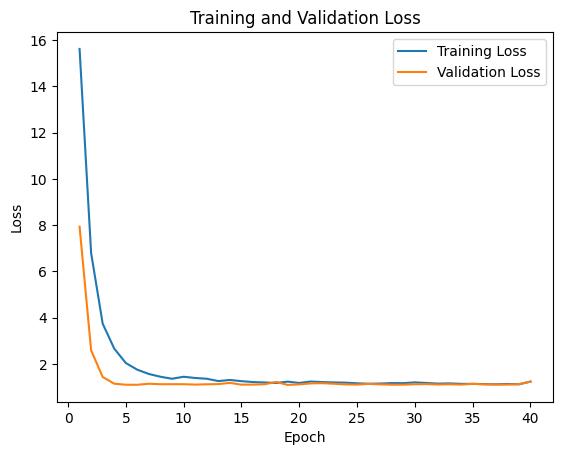


 Accuracy on test set is: 0.32


In [167]:
#Bonus Task 1 -
#mlp10 hidden states
model_1 = Net_1(max_dim=max_dim_2_0)#.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_2_10, val_dataloader_2_10, model_1, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)
acc = evaluate(test_dataloader_2_10, model_1)
print(f'\n Accuracy on test set is: {acc}')

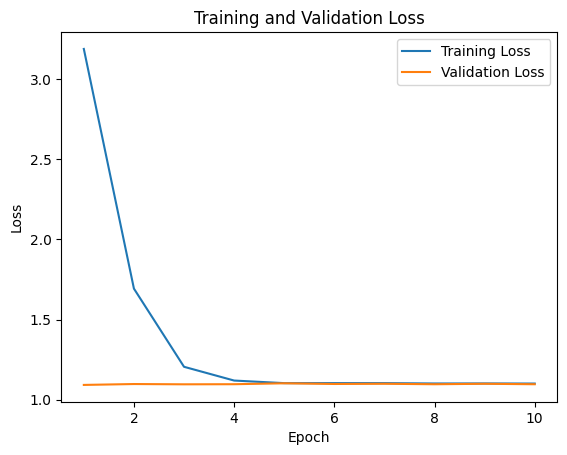

In [137]:
model_1 = Net_1(max_dim=max_dim_1_0)#.cuda()
epoch_num = 10
loss_fn = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model_1.parameters(), lr=0.5, weight_decay= lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_1, loss_fn, optimizer_SGD, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)

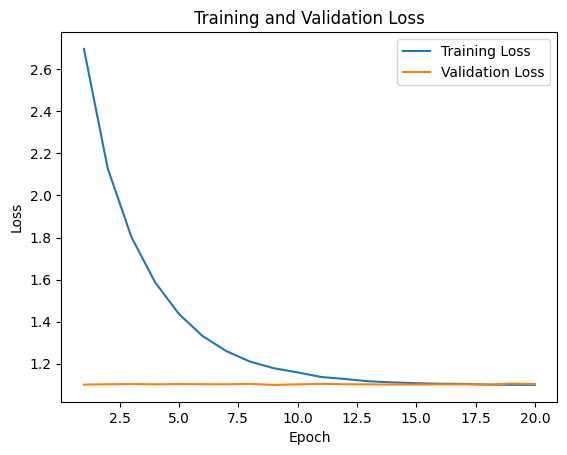

In [ ]:
model_1 = Net_1(max_dim=max_dim_1_0)#.cuda()
epoch_num = 20
loss_fn = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model_1.parameters(), lr=0.2, weight_decay= 0)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_1, loss_fn, optimizer_SGD, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)

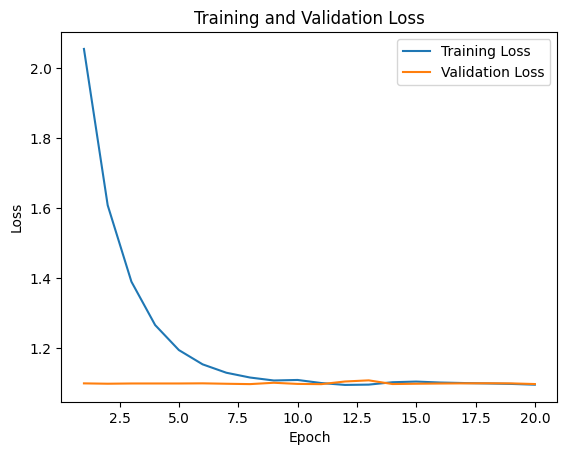

In [ ]:
model_1 = Net_1(max_dim=max_dim_1_0)#.cuda()
epoch_num = 20
loss_fn = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model_1.parameters(), lr=0.2, weight_decay= lambda_reg)
exp_1_train_loss, exp_1_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_1, loss_fn, optimizer_SGD, epoch_num)
plotting(epoch_num,exp_1_train_loss, exp_1_val_loss)

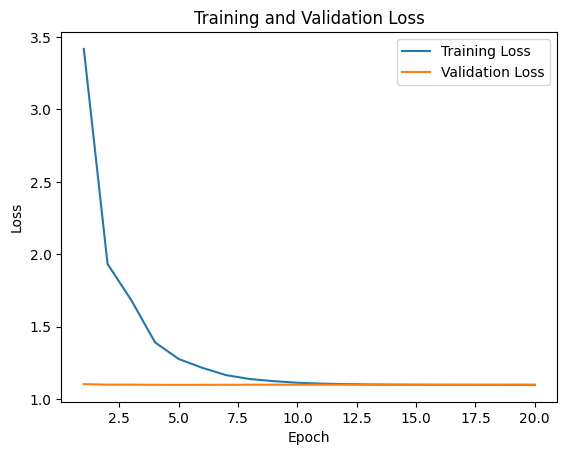

In [ ]:
model_2 = Net_2(max_dim=max_dim_1_0)#.cuda()
epoch_num = 20
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay= lambda_reg)
exp_2_train_loss, exp_2_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_2, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_2_train_loss, exp_2_val_loss)

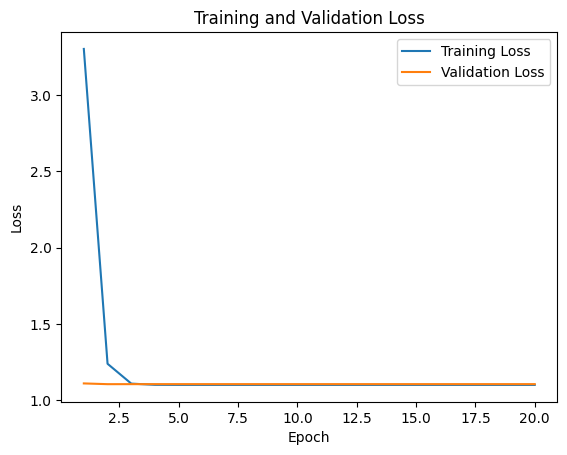

In [ ]:
model_2 = Net_2(max_dim=max_dim_1_0)#.cuda()
epoch_num = 20
loss_fn = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model_2.parameters(), lr=0.9, weight_decay= lambda_reg)
exp_2_train_loss, exp_2_val_loss = train_many_epochs(train_dataloader_2_5, val_dataloader_2_5, model_2, loss_fn, optimizer_SGD, epoch_num)
plotting(epoch_num,exp_2_train_loss, exp_2_val_loss)

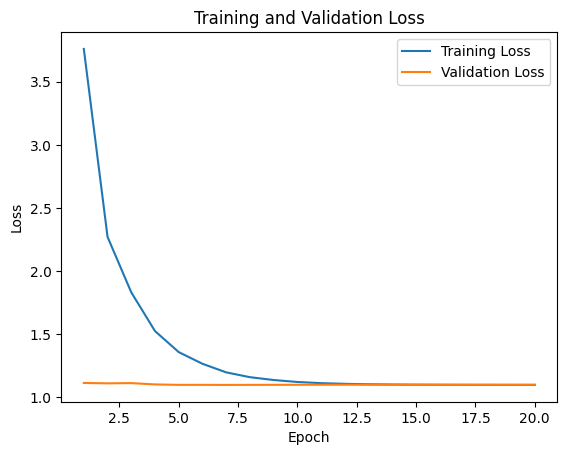

In [ ]:
model_3 = Net_3(max_dim=max_dim_1_0, dropout_prob=0.2)#.cuda()
epoch_num = 20
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_3.parameters(), lr=learning_rate, weight_decay= lambda_reg)
exp_3_train_loss, exp_3_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_3, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_3_train_loss, exp_3_val_loss)

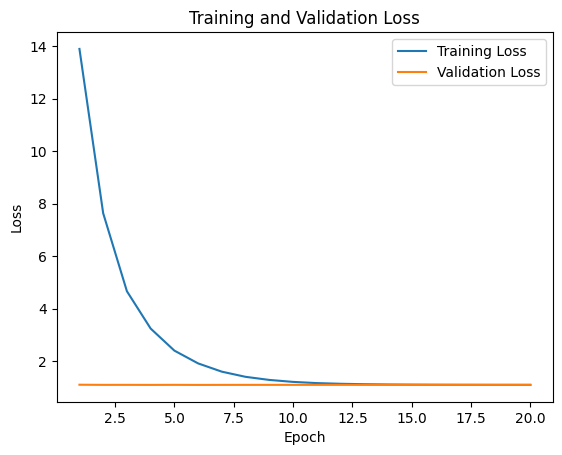

In [ ]:
model_4 = Net_4(max_dim=max_dim_1_0, dropout_prob=0.2)#.cuda()
epoch_num = 20
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_4.parameters(), lr=learning_rate, weight_decay= lambda_reg)
exp_4_train_loss, exp_4_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_4, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num,exp_4_train_loss, exp_4_val_loss)

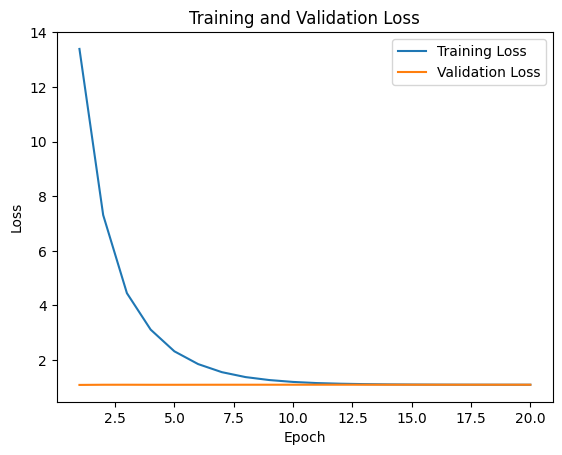

In [ ]:
model_5 = Net_5(max_dim=max_dim_1_0)#.cuda()
epoch_num = 20
loss_fn = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_5.parameters(), lr=learning_rate, weight_decay= lambda_reg)
exp_5_train_loss, exp_5_val_loss = train_many_epochs(train_dataloader_1_0, val_dataloader_1_0, model_5, loss_fn, optimizer_Adam, epoch_num)
plotting(epoch_num, exp_5_train_loss, exp_5_val_loss)

# Find Optimal Lambda and Learning Rate

In [ ]:
lambda_reg, learning_rate

(0.009, 0.014)

In [ ]:
# #learning_rate_increase = 0.003
# learning_rates = [learning_rate+learning_rate_increase*i for i in range(0,8) ]
# lambda_decrease = 0.001
# lambdas = [lambda_reg-i*lambda_decrease for i in range(0,19)]

learning_rates = [0.00001+(0.01-0.00001)/4*i for i in range(8)]
lambdas = [0.001*10**i for i in range(6)]
learning_rates, lambdas

([1e-05,
  0.0025075,
  0.005005,
  0.0075025000000000005,
  0.01,
  0.0124975,
  0.014995000000000001,
  0.0174925],
 [0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

In [ ]:
import math
#create a function to store train val losses to find optimal different lambdas and learning rates
def compare_lamdas(train_dataloader, val_dataloader, epochs, lr= learning_rate, lambdas=lambdas):

  val_loss_list = []
  for ld in lambdas:
      model = Net_1(max_dim=max_dim_0).cuda()
      optimizer_Adam = optim.Adam(model.parameters(), lr=lr, weight_decay= ld)
      tmp = train_many_epochs(train_dataloader, val_dataloader, model, loss_fn, optimizer_Adam, epochs)
      train_loss, val_loss  = tmp
      val_loss_list.append(val_loss[-1])

  log_lambdas = [math.log10(l) for l in lambdas]
  plt.plot(log_lambdas, val_loss_list, label='Validation Loss')
  plt.title('Lambdas & Validation Loss')
  plt.xlabel('Lambdas (log10)')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

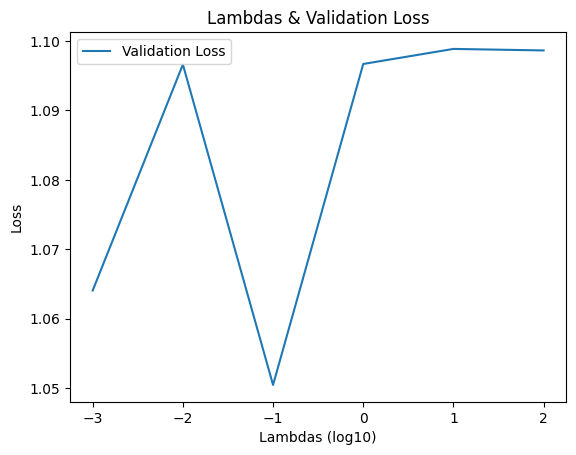

In [ ]:
compare_lamdas(train_dataloader_0, val_dataloader_0, 20, learning_rate, lambdas)

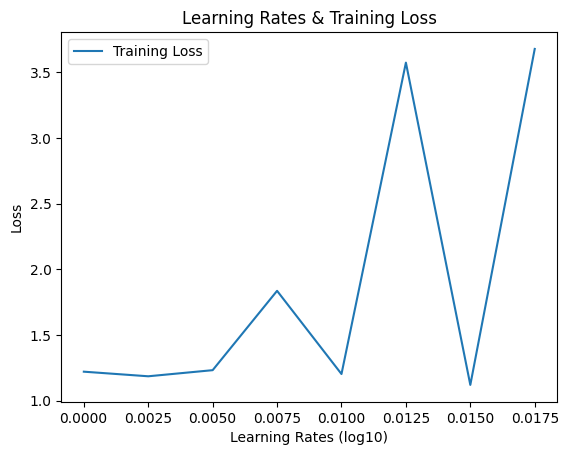

In [ ]:
#find the optimal learning rate
#https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

model_1 = Net_1(max_dim=max_dim_0).cuda()
train_loss_list = []

for i, (x_batch, y_batch) in enumerate(train_dataloader_0, 0):
    x = x_batch.cuda()
    y = y_batch.cuda()

    learning_rate = learning_rates[i]
    optimizer_Adam = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay= lambda_reg)
    # Clear the gradients
    optimizer_Adam.zero_grad()

    # Run a forward pass
    # The forward method defines the forward pass of the network, which specifies how input data is processed through the layers to produce an output.
    logits = model_1(x)

    # Compute the batch loss
    loss = loss_fn(logits, y) + lambda_reg * sum(torch.sum(param**2) for param in model_1.parameters())

    # Calculate the gradients
    loss.backward()

    # Update the parameteres
    optimizer_Adam.step()

    train_loss_list.append(loss.item())

#log_lr = [math.log10(l) for l in learning_rates]
plt.plot(learning_rates, train_loss_list, label='Training Loss')
plt.title('Learning Rates & Training Loss')
plt.xlabel('Learning Rates (log10)')
plt.ylabel('Loss')
plt.legend()
plt.show()

#We need to select a point on the graph with the fastest decrease in the loss.

In [ ]:
#create a function to store train val losses to find optimal different lambdas and learning rates
def compare_lamdas_learnrates(max_dim, train_dataloader, val_dataloader, epochs, learning_rates, lambdas):
  comparison = {}
  for ld in lambdas:
    comparison[str(ld)] = {}

    for lr in learning_rates:
      model = Net(max_dim).cuda()
      optimizer_Adam = optim.Adam(model.parameters(), lr=lr, weight_decay= ld)
      tmp = train_many_epochs(train_dataloader, val_dataloader, model, loss_fn, optimizer_Adam, epochs)

      comparison[str(ld)][str(lr)] = {'train_loss': 0.00, 'val_loss': 0.00}
      comparison[str(ld)][str(lr)]['train_loss'] = tmp[0]
      comparison[str(ld)][str(lr)]['val_loss'] = tmp[1]

  return comparison

In [ ]:
#create a function to plot train val loss

import matplotlib.pyplot as plt
def plotting(epoch_num, train_loss_list, val_loss_list):
    epochs = range(1, epoch_num + 1)

    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

lambda: 0.01, learning rate: 0.01



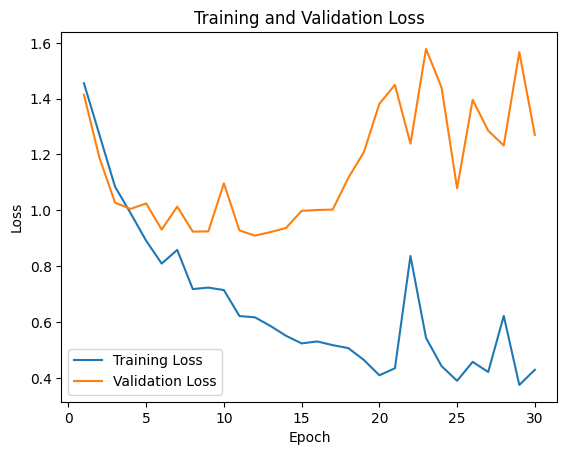

lambda: 0.01, learning rate: 0.007



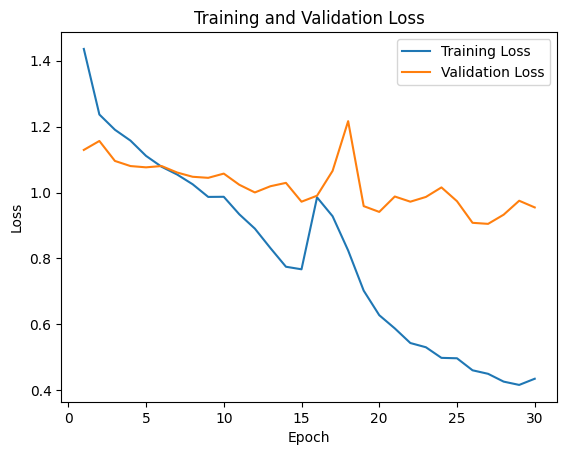

lambda: 0.01, learning rate: 0.004



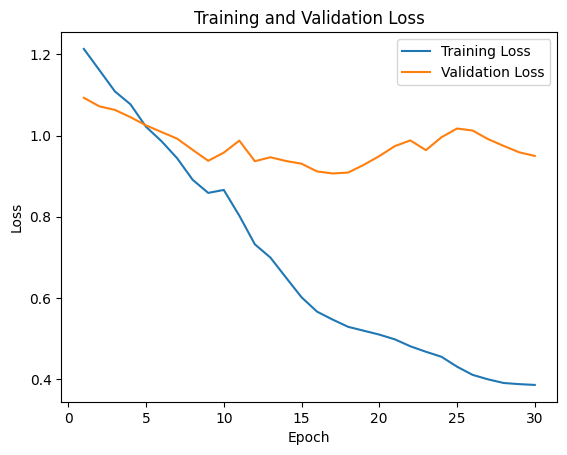

lambda: 0.01, learning rate: 0.0009999999999999992



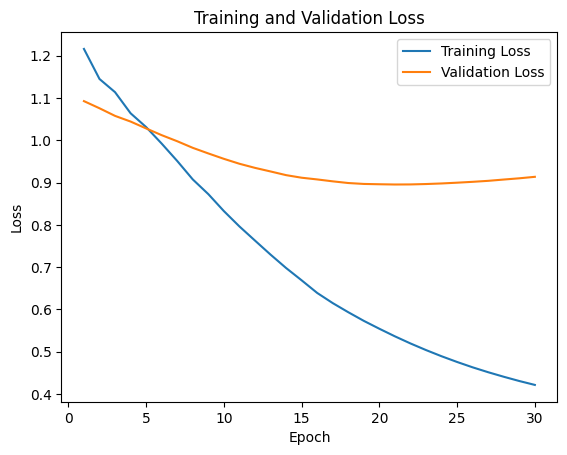

lambda: 0.007, learning rate: 0.01



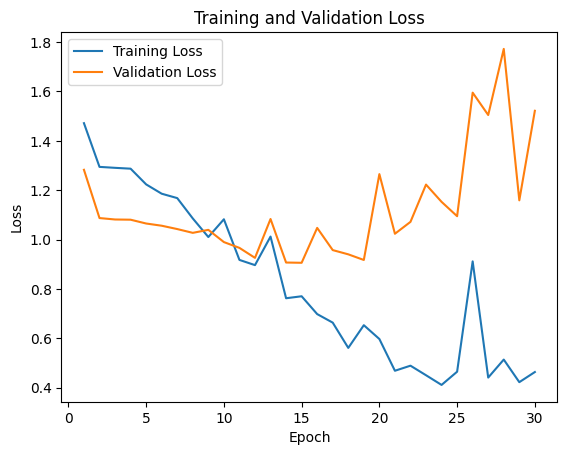

lambda: 0.007, learning rate: 0.007



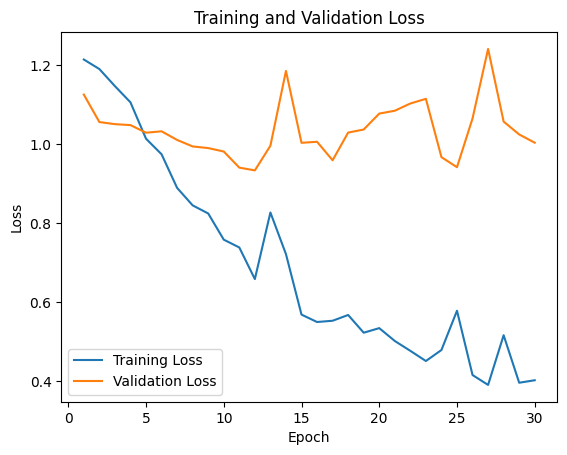

lambda: 0.007, learning rate: 0.004



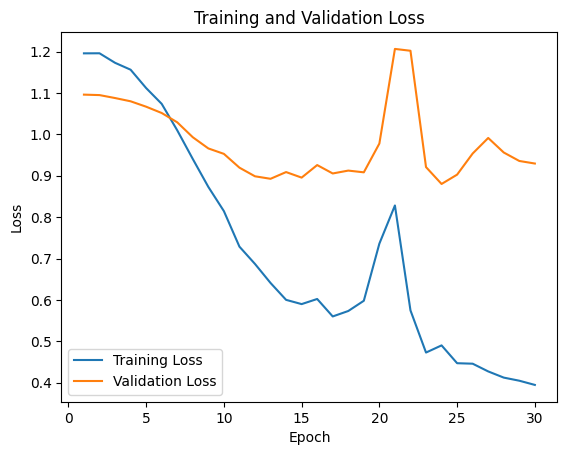

lambda: 0.007, learning rate: 0.0009999999999999992



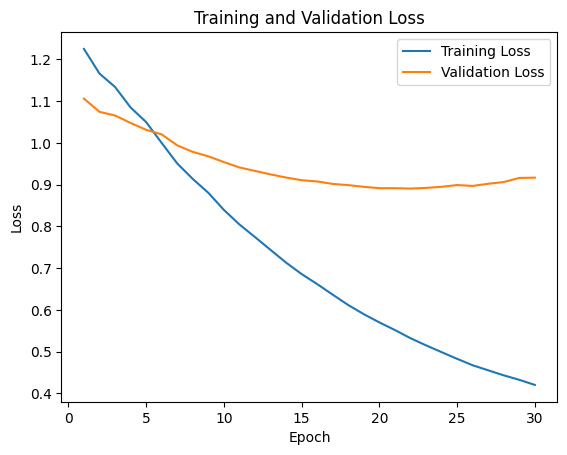

lambda: 0.004, learning rate: 0.01



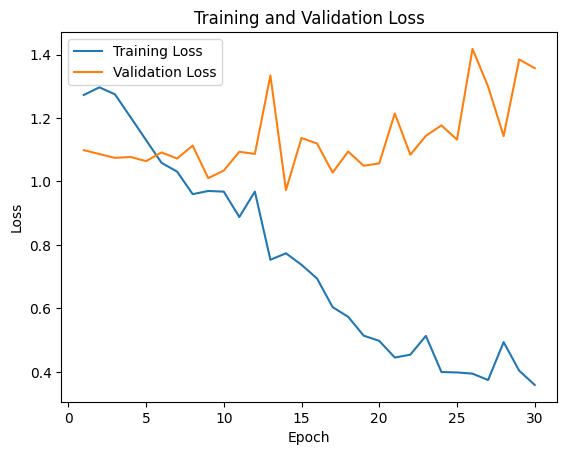

lambda: 0.004, learning rate: 0.007



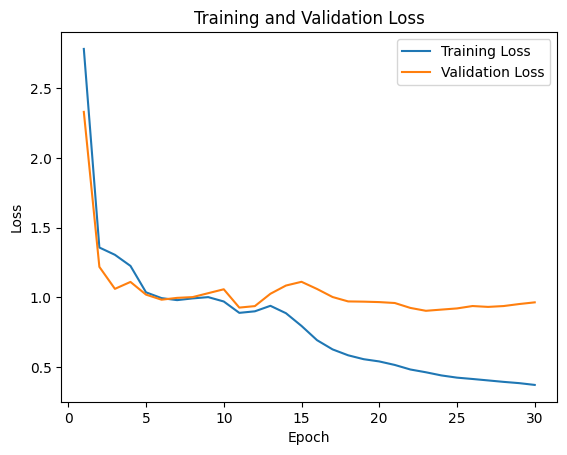

lambda: 0.004, learning rate: 0.004



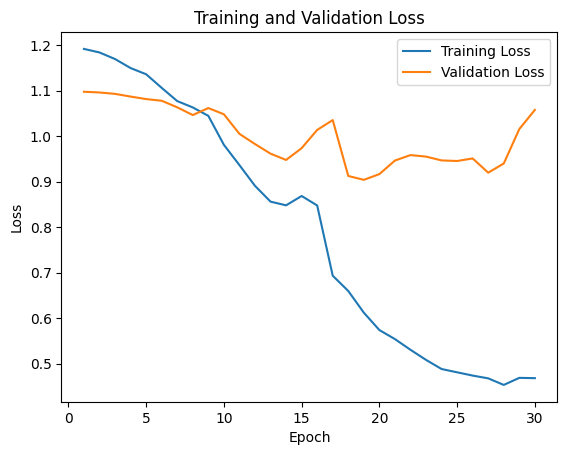

lambda: 0.004, learning rate: 0.0009999999999999992



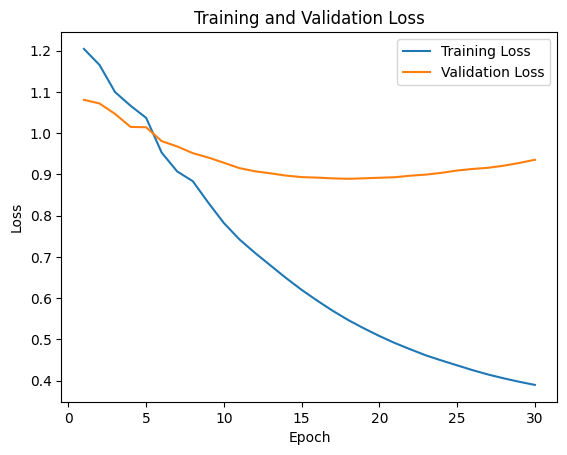

lambda: 0.0009999999999999992, learning rate: 0.01



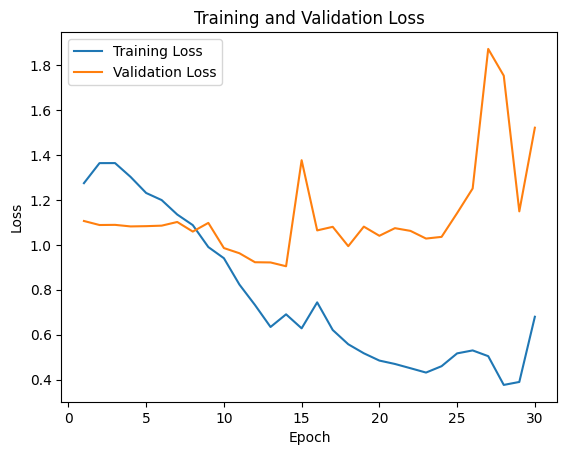

lambda: 0.0009999999999999992, learning rate: 0.007



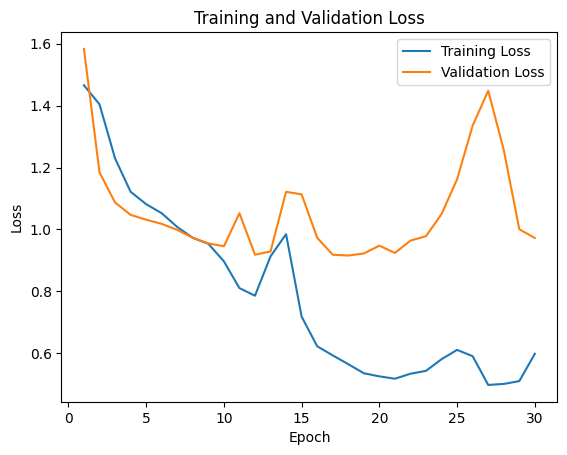

lambda: 0.0009999999999999992, learning rate: 0.004



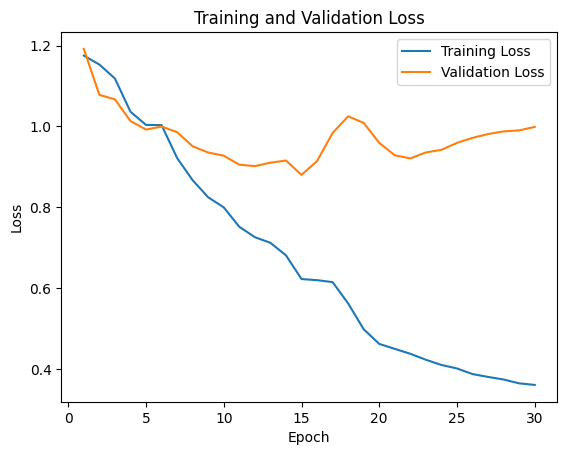

lambda: 0.0009999999999999992, learning rate: 0.0009999999999999992



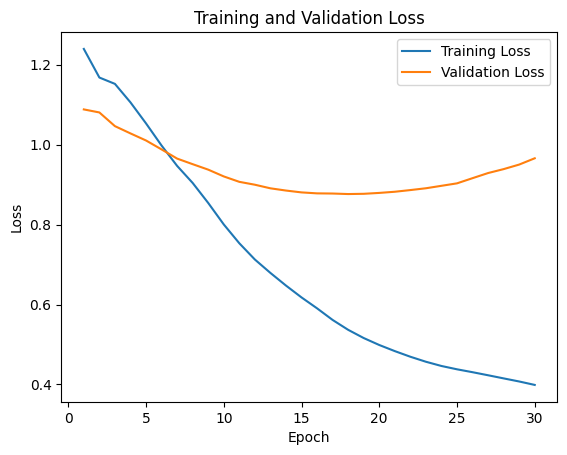

In [ ]:
for ld in comparison_0:
  for lr in comparison_0[ld]:
    print(f'lambda: {ld}, learning rate: {lr}\n')
    train_loss_list = comparison_0[ld][lr]['train_loss']
    val_loss_list = comparison_0[ld][lr]['val_loss']
    plot = plotting(30, train_loss_list=train_loss_list, val_loss_list=val_loss_list)

lambda: 0.01, learning rate: 0.01



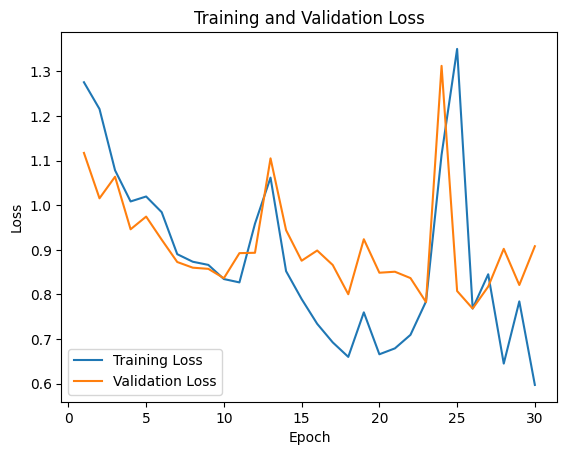

lambda: 0.01, learning rate: 0.007



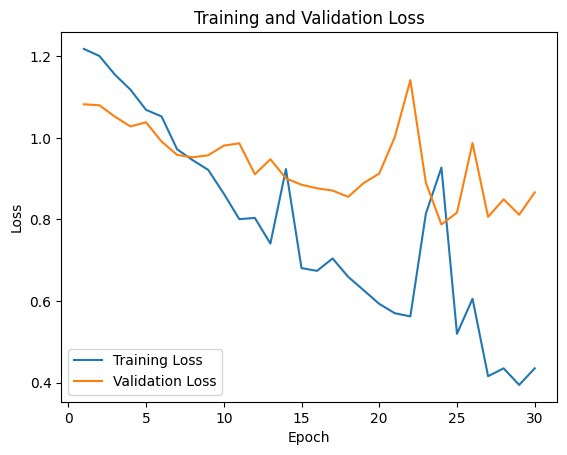

lambda: 0.01, learning rate: 0.004



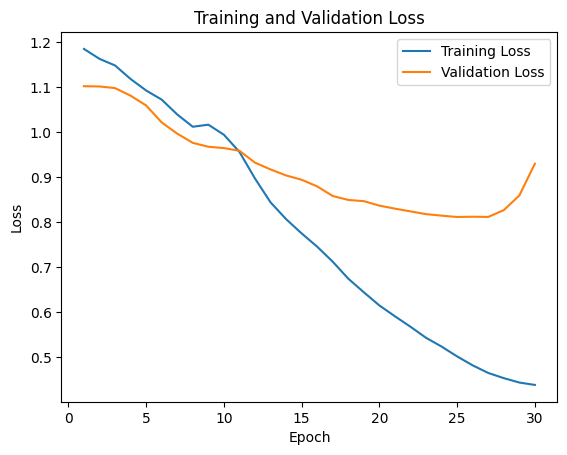

lambda: 0.01, learning rate: 0.0009999999999999992



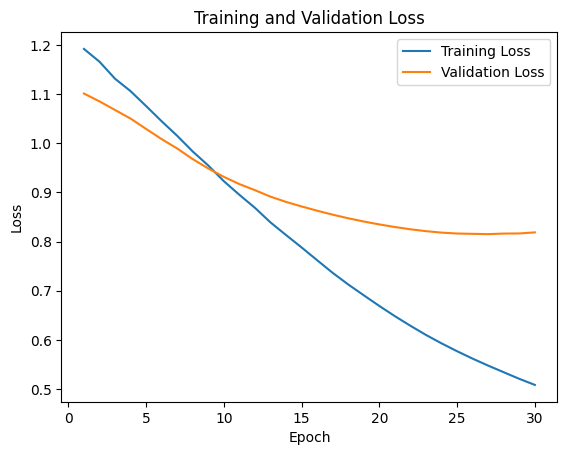

lambda: 0.007, learning rate: 0.01



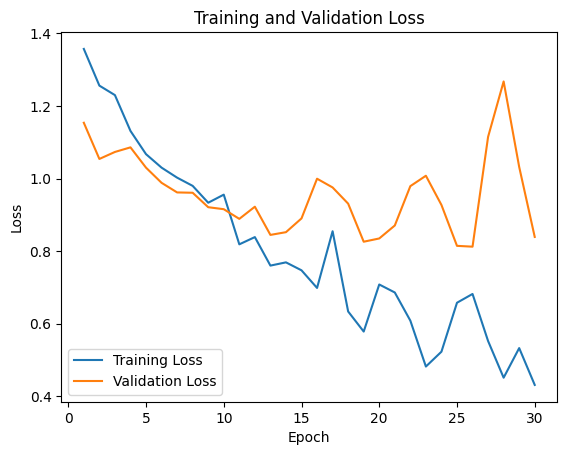

lambda: 0.007, learning rate: 0.007



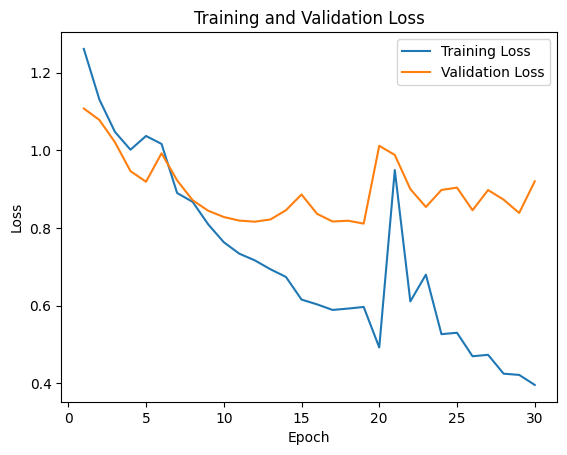

lambda: 0.007, learning rate: 0.004



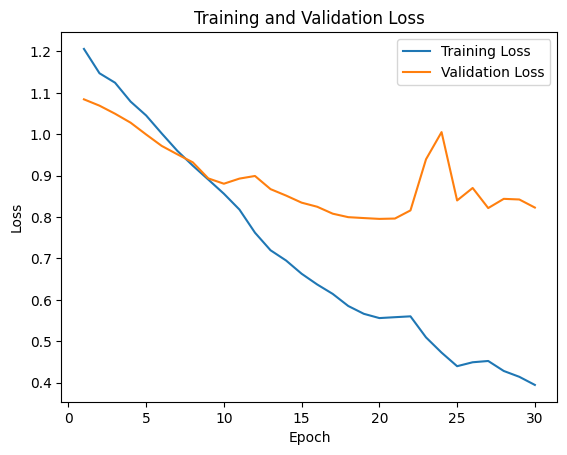

lambda: 0.007, learning rate: 0.0009999999999999992



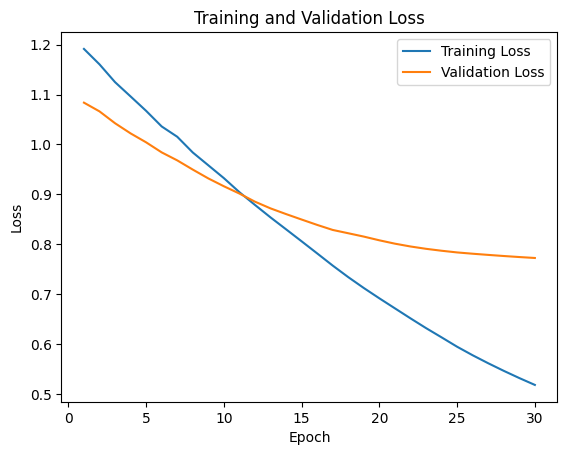

lambda: 0.004, learning rate: 0.01



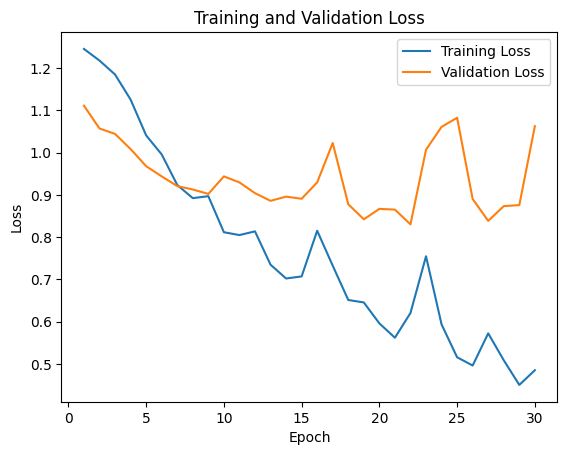

lambda: 0.004, learning rate: 0.007



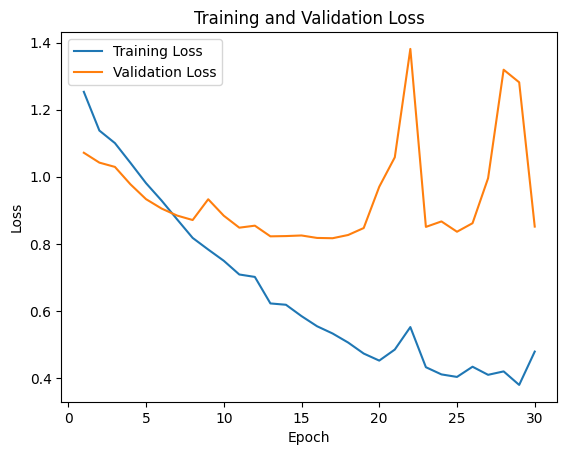

lambda: 0.004, learning rate: 0.004



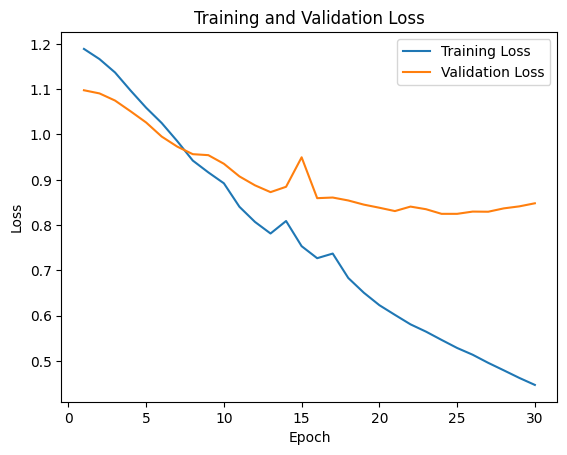

lambda: 0.004, learning rate: 0.0009999999999999992



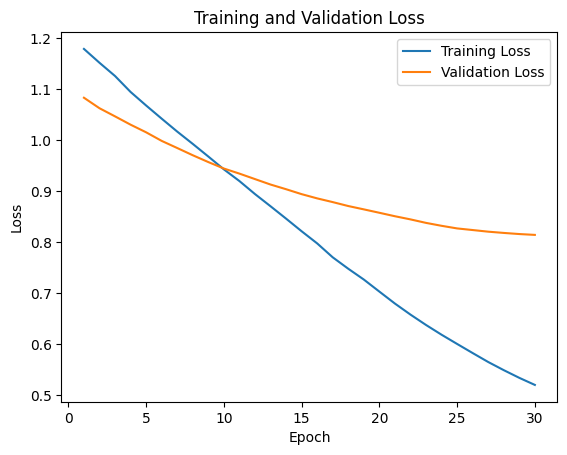

lambda: 0.0009999999999999992, learning rate: 0.01



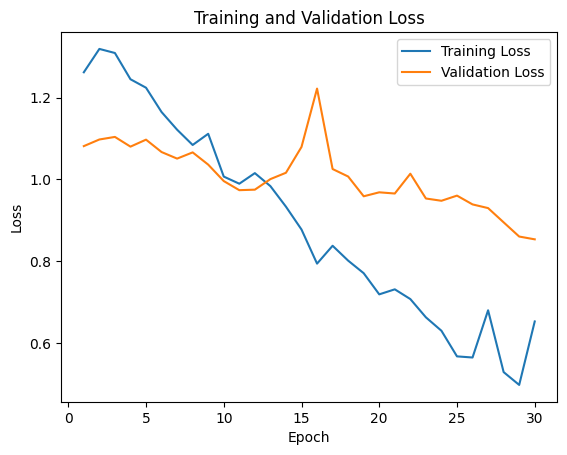

lambda: 0.0009999999999999992, learning rate: 0.007



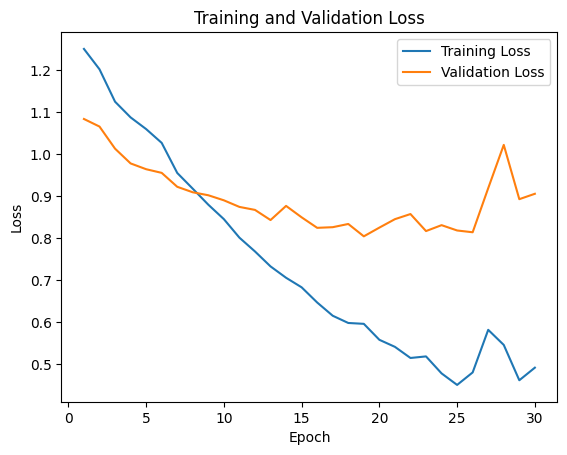

lambda: 0.0009999999999999992, learning rate: 0.004



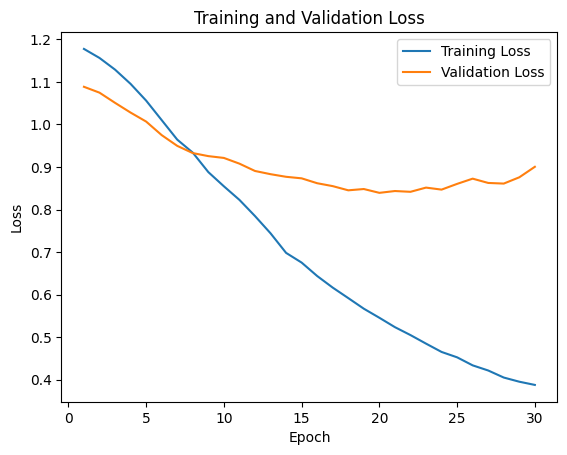

lambda: 0.0009999999999999992, learning rate: 0.0009999999999999992



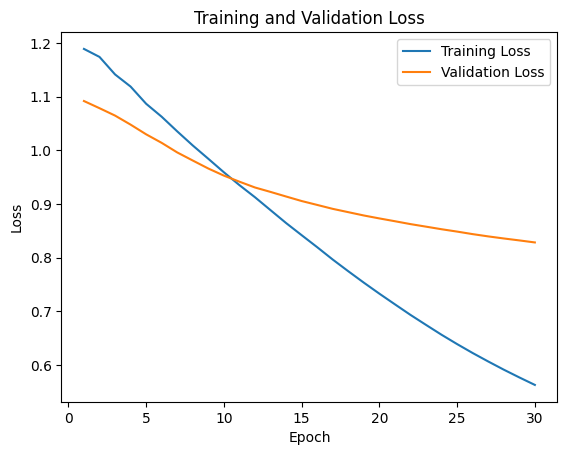

In [ ]:
comparison_5 = compare_lamdas_learnrates(max_dim_5, train_dataloader_5, val_dataloader_5, 30)
for ld in comparison_5:
  for lr in comparison_5[ld]:
    print(f'lambda: {ld}, learning rate: {lr}\n')
    train_loss_list = comparison_5[ld][lr]['train_loss']
    val_loss_list = comparison_5[ld][lr]['val_loss']
    plot = plotting(30, train_loss_list=train_loss_list, val_loss_list=val_loss_list)

lambda: 0.01, learning rate: 0.01



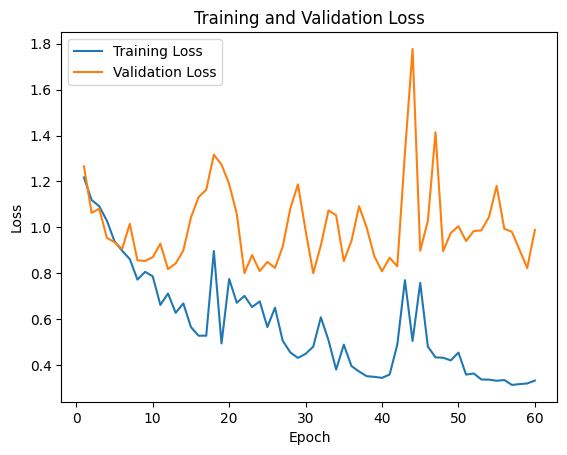

lambda: 0.25, learning rate: 0.01



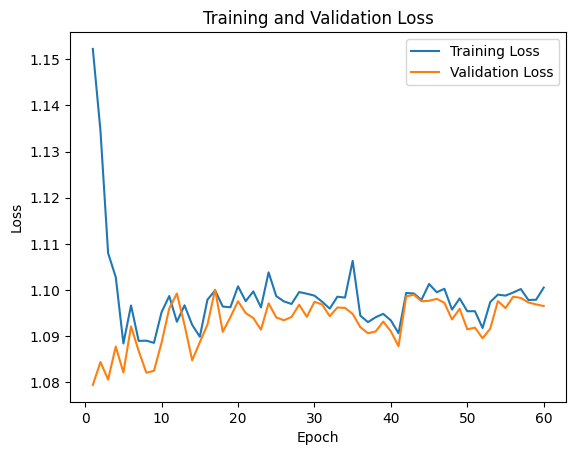

In [ ]:
learning_rates_5 = [0.01]
lambdas_5 = [0.01, 0.25]
comparison_5 = compare_lamdas_learnrates(max_dim_5, train_dataloader_5, val_dataloader_5, 60, learning_rates_5, lambdas_5)
for ld in comparison_5:
  for lr in comparison_5[ld]:
    print(f'lambda: {ld}, learning rate: {lr}\n')
    train_loss_list = comparison_5[ld][lr]['train_loss']
    val_loss_list = comparison_5[ld][lr]['val_loss']
    plot = plotting(60, train_loss_list=train_loss_list, val_loss_list=val_loss_list)

lambda: 0.01, learning rate: 0.01



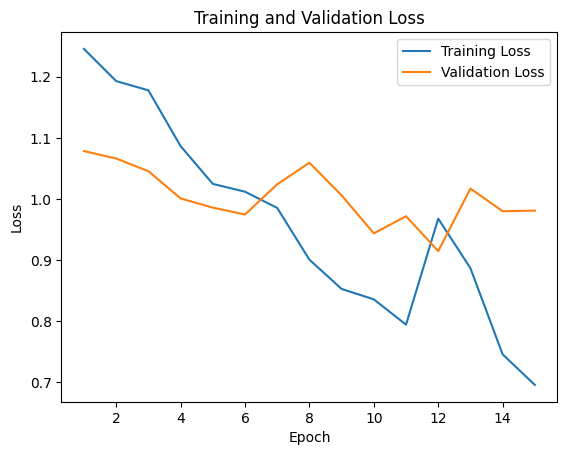

In [ ]:
learning_rates_5 = [0.01]
lambdas_5 = [0.01]
comparison_5 = compare_lamdas_learnrates(max_dim_5, train_dataloader_5, val_dataloader_5, 15, learning_rates_5, lambdas_5)
for ld in comparison_5:
  for lr in comparison_5[ld]:
    print(f'lambda: {ld}, learning rate: {lr}\n')
    train_loss_list = comparison_5[ld][lr]['train_loss']
    val_loss_list = comparison_5[ld][lr]['val_loss']
    plot = plotting(15, train_loss_list=train_loss_list, val_loss_list=val_loss_list)

lambda: 0.01, learning rate: 0.01



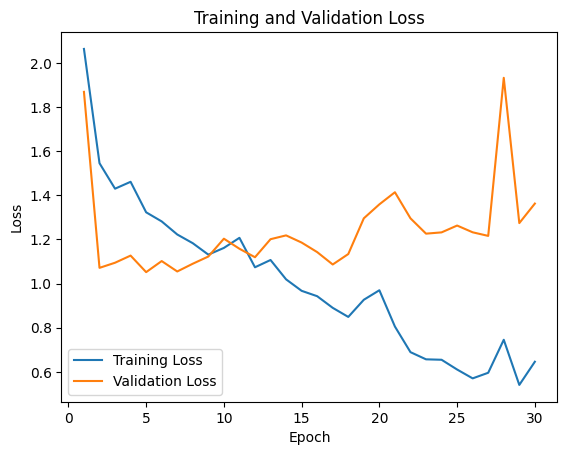

lambda: 0.01, learning rate: 0.007



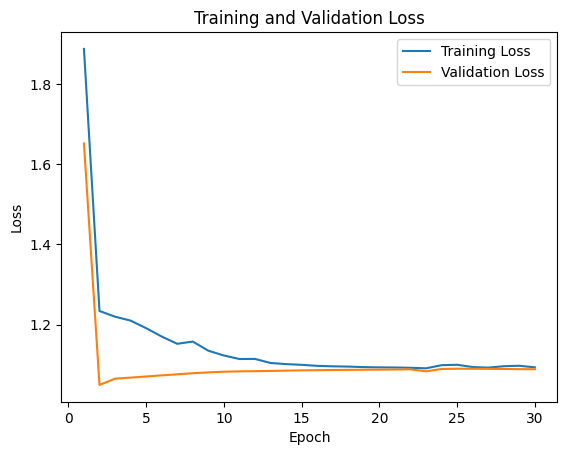

lambda: 0.01, learning rate: 0.004



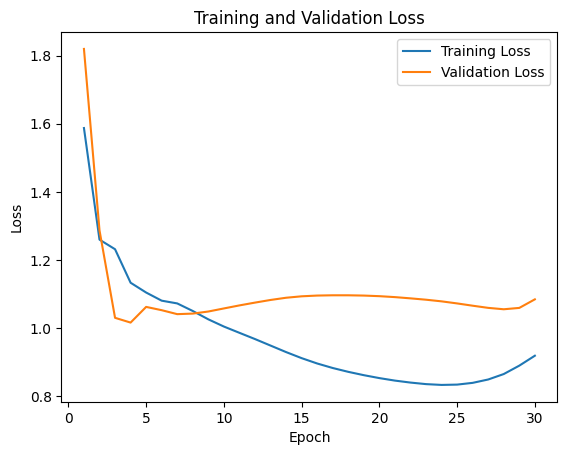

lambda: 0.01, learning rate: 0.0009999999999999992



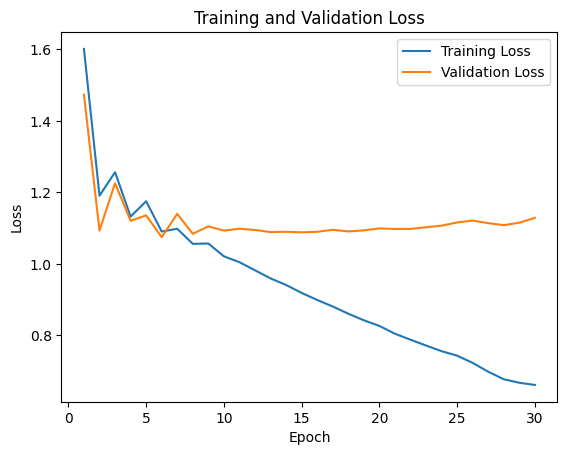

lambda: 0.007, learning rate: 0.01



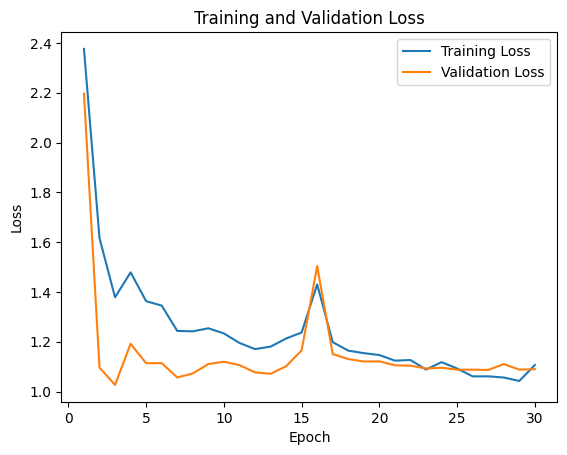

lambda: 0.007, learning rate: 0.007



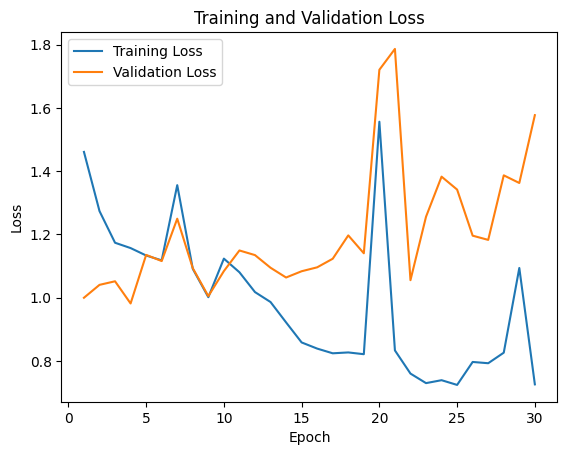

lambda: 0.007, learning rate: 0.004



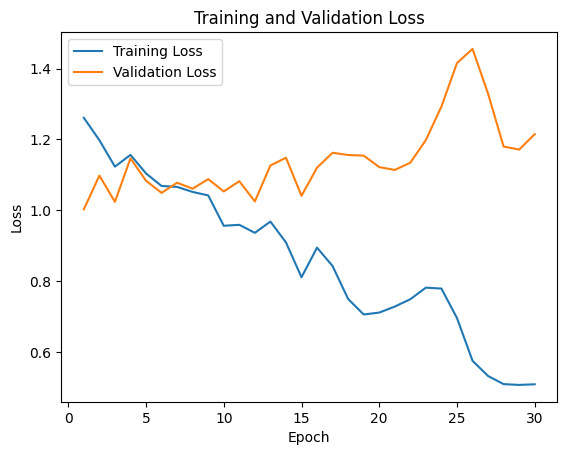

lambda: 0.007, learning rate: 0.0009999999999999992



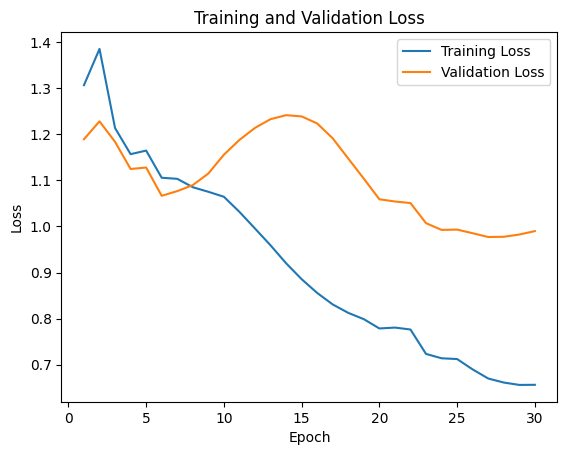

lambda: 0.004, learning rate: 0.01



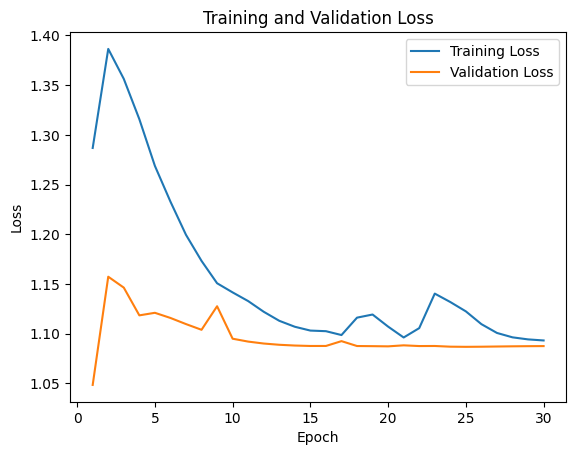

lambda: 0.004, learning rate: 0.007



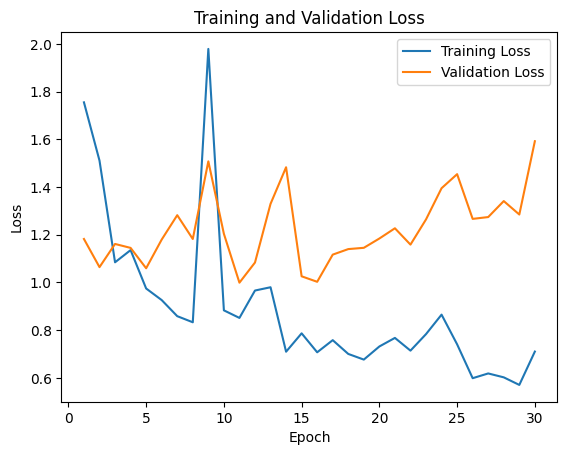

lambda: 0.004, learning rate: 0.004



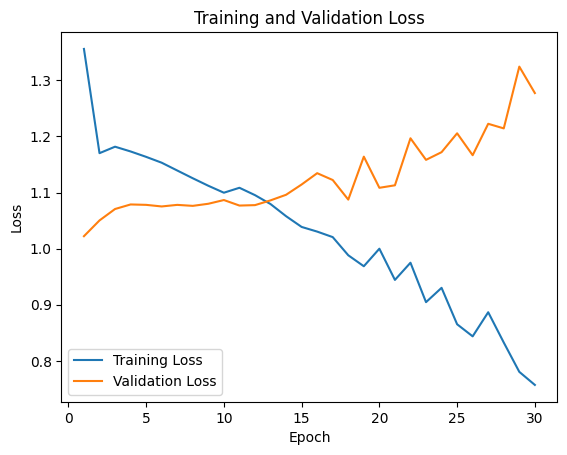

lambda: 0.004, learning rate: 0.0009999999999999992



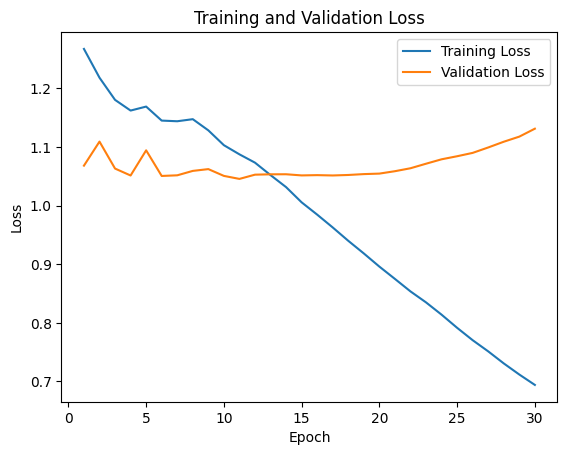

lambda: 0.0009999999999999992, learning rate: 0.01



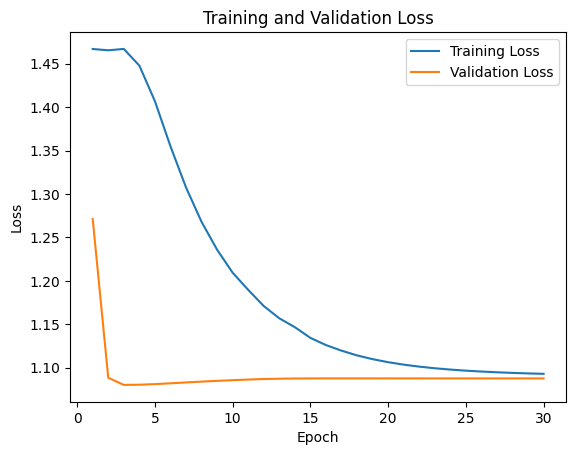

lambda: 0.0009999999999999992, learning rate: 0.007



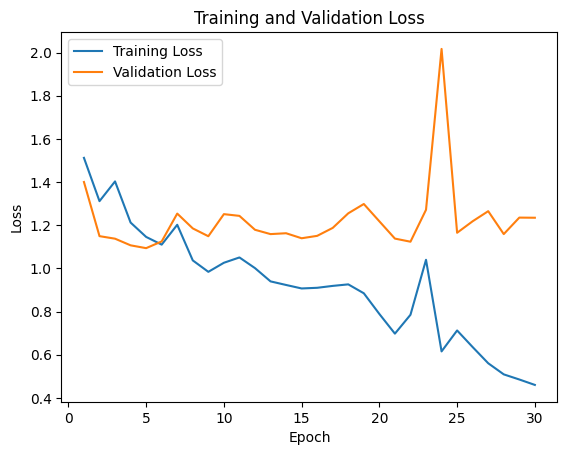

lambda: 0.0009999999999999992, learning rate: 0.004



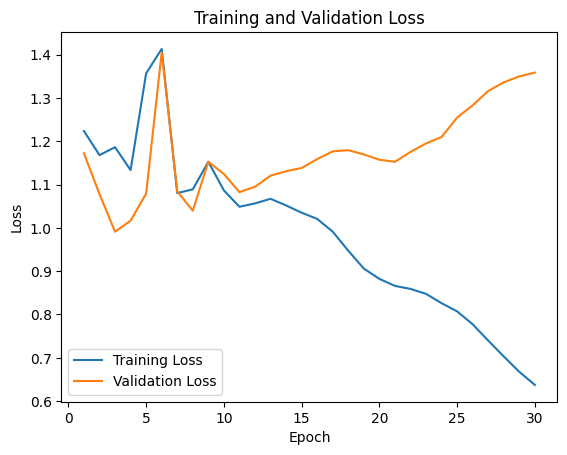

lambda: 0.0009999999999999992, learning rate: 0.0009999999999999992



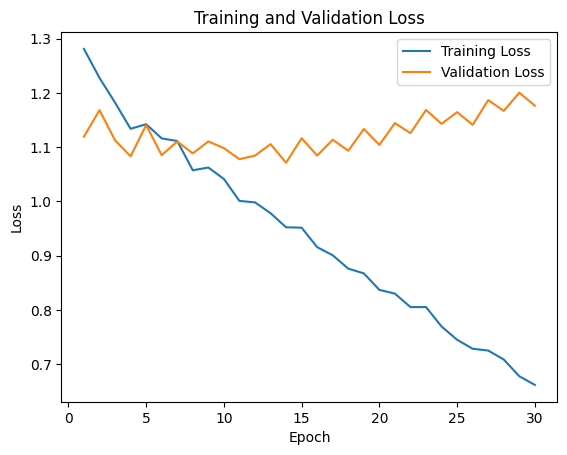

In [ ]:
comparison_10 = compare_lamdas_learnrates(max_dim_10, train_dataloader_10, val_dataloader_10, 30)
for ld in comparison_10:
  for lr in comparison_10[ld]:
    print(f'lambda: {ld}, learning rate: {lr}\n')
    train_loss_list = comparison_10[ld][lr]['train_loss']
    val_loss_list = comparison_10[ld][lr]['val_loss']
    plot = plotting(30, train_loss_list=train_loss_list, val_loss_list=val_loss_list)

In [47]:
class_count = {'contradiction':0, 'neutral':0, 'entailment':0}
for tup in train_tuples_2:
    if tup[0] == 'contradiction':
        class_count['contradiction'] += 1
    elif tup[0] =='neutral':
        class_count['neutral'] += 1
    else:
        class_count['entailment'] += 1

class_count

{'contradiction': 168, 'neutral': 177, 'entailment': 155}

In [48]:
[count/500 for entailment, count in class_count.items()]

[0.336, 0.354, 0.31]

# Jump to bottom